In [1]:
import glob
import os
import re
import string
from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prody
import py3Dmol
import seaborn as sns
from ipywidgets import interact
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from scipy.spatial.distance import cdist
from scipy.stats import describe
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

RDKit WARNING: [09:45:30] Enabling RDKit 2019.09.3 jupyter extensions


### Prody Basics
We begin by reading in the apo Mpro structure 6YB7 and taking a look at some of the capabilities provided by [Prody](http://prody.csb.pitt.edu/) 

In [2]:
# read pdb file into a prody AtomGroup
apo_file = 'diamond_apo_mpro/6YB7.pdb'
apo_struct = prody.parsePDB(apo_file)
apo_struct

@> 4682 atoms and 1 coordinate set(s) were parsed in 0.04s.


<AtomGroup: 6YB7 (4682 atoms)>

In [3]:
# AtomGroup properties
print(f'No. atoms: {apo_struct.numAtoms()}')
print(f'No. residues: {apo_struct.numResidues()}')
print(f'No. chains: {apo_struct.numChains()}')

No. atoms: 4682
No. residues: 306
No. chains: 1


In [4]:
# per-atom properties
print(f'Names: {apo_struct.getNames()}')
print(f'Resnums: {apo_struct.getResnums()}')
print(f'Resnames: {apo_struct.getResnames()}')
print(f'Chains: {apo_struct.getChids()}')

Names: ['N' 'CA' 'C' ... 'HG2' 'HE22' 'HE21']
Resnums: [  1   1   1 ... 306 306 306]
Resnames: ['SER' 'SER' 'SER' ... 'GLN' 'GLN' 'GLN']
Chains: ['A' 'A' 'A' ... 'A' 'A' 'A']


In [5]:
# Hierarchical Indexing
apo_struct['A']

<Chain: A from 6YB7 (306 residues, 4682 atoms)>

In [6]:
apo_struct['A', 30]

<Residue: LEU 30 from Chain A from 6YB7 (19 atoms)>

In [7]:
# get atomic coordinates
apo_struct.getCoords()

array([[ -2.471,   4.23 , -17.183],
       [ -1.988,   5.462, -16.536],
       [ -2.415,   5.516, -15.063],
       ...,
       [  4.987, -17.409,  -9.532],
       [  7.697, -19.48 ,  -8.545],
       [  6.203, -18.674,  -8.11 ]])

In [8]:
# parse out the backbone coordinates
bb = apo_struct.select('backbone')
bb

<Selection: 'backbone' from 6YB7 (1224 atoms)>

In [9]:
bb.getCoords()

array([[ -2.471,   4.23 , -17.183],
       [ -1.988,   5.462, -16.536],
       [ -2.415,   5.516, -15.063],
       ...,
       [  5.582, -14.855,  -9.291],
       [  5.941, -15.331,  -7.881],
       [  7.071, -15.673,  -7.538]])

In [10]:
# parse out a specific residue and get it's coordinates
apo_struct['A', 30].getCoords()

array([[  9.925, -13.741,  12.009],
       [ 10.021, -14.099,  10.601],
       [ 10.667, -15.489,  10.525],
       [ 11.842, -15.639,  10.844],
       [ 10.913, -13.051,   9.896],
       [ 10.986, -13.214,   8.363],
       [  9.659, -12.827,   7.694],
       [ 12.157, -12.42 ,   7.771],
       [ 10.796, -13.567,  12.496],
       [  9.034, -14.119,  10.139],
       [ 11.92 , -13.086,  10.311],
       [ 10.546, -12.049,  10.126],
       [ 11.174, -14.258,   8.125],
       [  9.721, -12.902,   6.609],
       [  8.843, -13.474,   8.012],
       [  9.37 , -11.809,   7.949],
       [ 12.174, -12.509,   6.687],
       [ 12.087, -11.359,   7.986],
       [ 13.113, -12.779,   8.152]])

___
### How Rigid/Flexible is Mpro?

Let's evaluate residue mobility accross the various apo and holo structures in the Diamond/XChem dataset

In [11]:
# locate files
non_cov_files = glob.glob('diamond_non_cov_mpro/*.pdb')
cov_files = glob.glob('diamond_cov_mpro/*.pdb')

# read files into Prody AtomGroups
non_cov_structs = prody.parsePDB(non_cov_files)
cov_structs = prody.parsePDB(cov_files)

@> 22 PDBs were parsed in 0.80s.                                
@> 44 PDBs were parsed in 1.67s.                            


In [12]:
non_cov_structs

[<AtomGroup: Mpro-x0995_1 (4658 atoms)>,
 <AtomGroup: Mpro-x0540_1 (4684 atoms)>,
 <AtomGroup: Mpro-x0354_1 (4684 atoms)>,
 <AtomGroup: Mpro-x1249_1 (4678 atoms)>,
 <AtomGroup: Mpro-x0678_1 (4679 atoms)>,
 <AtomGroup: Mpro-x0195_1 (4674 atoms)>,
 <AtomGroup: Mpro-x0991_1 (4659 atoms)>,
 <AtomGroup: Mpro-x1077_1 (4673 atoms)>,
 <AtomGroup: Mpro-x1093_1 (4683 atoms)>,
 <AtomGroup: Mpro-x0395_1 (4673 atoms)>,
 <AtomGroup: Mpro-x0397_1 (4675 atoms)>,
 <AtomGroup: Mpro-x0426_1 (4676 atoms)>,
 <AtomGroup: Mpro-x0874_1 (4671 atoms)>,
 <AtomGroup: Mpro-x0072_1 (4671 atoms)>,
 <AtomGroup: Mpro-x0104_1 (4674 atoms)>,
 <AtomGroup: Mpro-x0305_1 (4665 atoms)>,
 <AtomGroup: Mpro-x0967_1 (4681 atoms)>,
 <AtomGroup: Mpro-x0161_1 (4669 atoms)>,
 <AtomGroup: Mpro-x0107_1 (4666 atoms)>,
 <AtomGroup: Mpro-x0387_1 (4674 atoms)>,
 <AtomGroup: Mpro-x0946_1 (4662 atoms)>,
 <AtomGroup: Mpro-x0434_1 (4673 atoms)>]

In [13]:
# strip off hydrogens, we don't need them
apo_struct = apo_struct.select('heavy').copy()
non_cov_structs = [ s.select('heavy').copy() for s in non_cov_structs ]
cov_structs = [ s.select('heavy').copy() for s in cov_structs ]

# extract protein
apo_struct = apo_struct.select('protein').copy()
non_cov_prot_structs = [ s.select('protein').copy() for s in non_cov_structs ]
cov_prot_structs = [ s.select('protein').copy() for s in cov_structs ]

### Using Prody Enesembles to Identify Flexible Regions
The ProDy PDBEnsemble class makes it easy to do certain types of comparisons/calculations on an ensemble of homologous or sequence-identical (like frames from an MD) protein structures.  

In [14]:
# build PDBEnsembles 
non_cov_ensemble = prody.buildPDBEnsemble(non_cov_prot_structs)
cov_ensemble = prody.buildPDBEnsemble(cov_prot_structs)

# align ensembles
non_cov_ensemble.iterpose()
cov_ensemble.iterpose()

@> Starting iterative superposition:                                                       
@> Step #1: RMSD difference = 1.1849e-01
@> Step #2: RMSD difference = 3.8693e-07
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (22 conformations) were built in 0.86s.
@> Starting iterative superposition:                                                       
@> Step #1: RMSD difference = 1.6537e-01
@> Step #2: RMSD difference = 3.8849e-07
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.01 seconds.
@> Ensemble (44 conformations) were built in 1.70s.
@> Starting iterative superposition:
@> Step #1: RMSD difference = 9.2634e-12
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.01 seconds.
@> Starting iterative superposition:
@

In [15]:
# Prody calculates RMSFs per atom, let's average accross residues
non_cov_rmsf = pd.DataFrame({
    'rmsf': non_cov_ensemble.getRMSFs(),
    'resnum': non_cov_ensemble.getAtoms().getResnums(),
    'resname': non_cov_ensemble.getAtoms().getResnames()
}).groupby('resnum').agg(np.mean)

cov_rmsf = pd.DataFrame({
    'rmsf': cov_ensemble.getRMSFs(),
    'resnum': cov_ensemble.getAtoms().getResnums(),
    'resname': cov_ensemble.getAtoms().getResnames()
}).groupby('resnum').agg(np.mean)

rmsf_df = non_cov_rmsf.merge(
    cov_rmsf, 
    left_index=True, 
    right_index=True,
    suffixes=('_non_cov', '_cov')
)
rmsf_df

,rmsf_non_cov,rmsf_cov
resnum,,
1,0.172231,0.136248
2,0.143564,0.125013
3,0.107904,0.112619
4,0.110428,0.090036
5,0.097995,0.082591
...,...,...
300,0.111305,0.131022
301,0.128207,0.153436
302,0.149995,0.177635


### Plot RMSF to compare the covalent and non-covalent sets

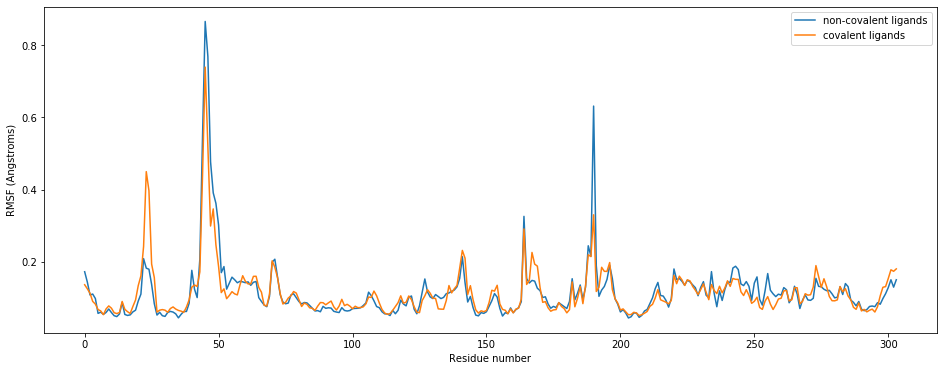

In [16]:
# plot the RMSFs
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(rmsf_df['rmsf_non_cov'].values, label='non-covalent ligands')
ax.plot(rmsf_df['rmsf_cov'].values, label='covalent ligands')
ax.set_xlabel('Residue number')
ax.set_ylabel('RMSF (Angstroms)')
ax.legend()

plt.show()

Write PDB files for the covalent and non-covalent structures.  Set the temperature factors for each atom to the RMSF values for that residue. By visualizing the temperature factors, we can see which regions of the protein are more flexible. 

In [17]:
# let's create a nice 3D structural visualizations
struct = non_cov_prot_structs[0]
for residue in struct['A']:
    rmsf = rmsf_df['rmsf_non_cov'][residue.getResnum()]
    residue.setBetas(rmsf*150)
prody.writePDB('non_cov_rmsf_betas.pdb', struct)

struct = cov_prot_structs[0]
for residue in struct['A']:
    rmsf = rmsf_df['rmsf_cov'][residue.getResnum()]
    residue.setBetas(rmsf*150)
prody.writePDB('cov_rmsf_betas.pdb', struct)

'cov_rmsf_betas.pdb'

Get some simple descriptive statistics on the RMSF values

In [18]:
describe(struct.getBetas())

DescribeResult(nobs=2347, minmax=(7.619111462298995, 110.85465890115563), mean=16.70439678233319, variance=102.58964041607254, skewness=4.253060096890112, kurtosis=27.056135854988497)

Use Py3DMol to visualized the RMSF values

In [19]:
struct = non_cov_prot_structs[0]
p = py3Dmol.view(500, 500)
buff = StringIO()
prody.writePDBStream(buff, struct)
p.addModel(buff.getvalue(), 'pdb')
p.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':'sinebow','min':0,'max':130}}})
p.setBackgroundColor('0xeeeeee')
p.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Select diverse receptor structures for docking

In [20]:
# identify residues that interact with ligands the most
contacts = []
for struct in non_cov_structs:
    contact_atoms = struct.select('sidechain within 4 of resname LIG').copy()
    contact_resnums = set(contact_atoms.getResnums())
    contacts += list(contact_resnums)
key_contacts = np.argsort(np.bincount(contacts))[-10:]
key_contacts

array([140, 144, 163, 145, 142, 166, 189, 165,  49,  41])

In [21]:
# extract coordinates of those residues in each structure
selstr = f'resnum {" ".join(key_contacts.astype(str))}'
contact_resid_structs = [ s.select(selstr).copy() for s in non_cov_structs ]
contact_resid_coords = [ s.getCoords() for s in contact_resid_structs ]
contact_resid_coords_flat = np.vstack([ c.flatten() for c in contact_resid_coords ])

Define a function to calculate pairwise RMSD for all pairs of structures

In [22]:
def rmsd_matrix(structure_list):
    rmsd_df = pd.DataFrame()

    for i in range(len(structure_list)):
        for j in range(i + 1):
            struct1 = structure_list[i]
            struct2 = structure_list[j]

            rmsd = prody.calcRMSD(struct1, struct2)
            rmsd_df.loc[
                struct1.getTitle().split()[0],
                struct2.getTitle().split()[0],
            ] = rmsd

    # reflect over diagonal
    rmsd_df = rmsd_df.fillna(0) + rmsd_df.T.fillna(0)
    return rmsd_df

Cluster the active site residues and visualize the clusters.  Use the slider below to set the number of clusters. 

In [23]:
color_list = ['red', 'blue', "cyan", "green", "yellow", "purple"]
@interact(n_clusters=(1,len(color_list),1))
def cluster_structs(n_clusters=3):
    global num_clusters, cluster_ids, cluster_centers, rmsd_df
    num_clusters = n_clusters
    km = KMeans(n_clusters=n_clusters)
    rmsd_df = rmsd_matrix(contact_resid_structs)
    cluster_ids = km.fit_predict(rmsd_df.values)
    cluster_centers = km.cluster_centers_

    letters = string.ascii_uppercase[0:num_clusters]

    cluster_chain_ids = [letters[x] for x in cluster_ids]
    for struct, ch_id in zip(contact_resid_structs, cluster_chain_ids):
        struct.setChids(ch_id)

    cluster_dict = {}
    for i in range(0, num_clusters):
        chain_id = letters[i]
        cluster_dict[chain_id] = {'chain': chain_id}

    p = py3Dmol.view(500, 500)
    for struct in contact_resid_structs:
        buff = StringIO()
        prody.writePDBStream(buff, struct)
        p.addModel(buff.getvalue(), 'pdb')

    for i in range(0, num_clusters):
        chain_id = letters[i]
        ch = {'chain': chain_id}
        p.setStyle(ch, {'stick': {'color': color_list[i]}})

    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p

interactive(children=(IntSlider(value=3, description='n_clusters', max=6, min=1), Output()), _dom_classes=('wi…

Find the structure closest to each cluster center.  Calculate the Euclindean distance between each cluster center adn the RMS values for each ligand.

In [24]:
dm = cdist(rmsd_df.values,cluster_centers)
min_idx = np.argmin(dm,axis=0)
center_list = [0] * dm.shape[0]
for x in min_idx:
    center_list[x] = 1
center_list

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]

Display the cluster centers

In [25]:
center_asite_structs = [x for (x,y) in zip(contact_resid_structs,center_list) if y]
p = py3Dmol.view(500, 500)
for struct in center_asite_structs:
    buff = StringIO()
    prody.writePDBStream(buff, struct)
    p.addModel(buff.getvalue(), 'pdb')
for i in range(0, num_clusters):
    chain_id = string.ascii_uppercase[i]
    ch = {'chain': chain_id}
    p.setStyle(ch, {'stick': {'color': color_list[i]}})
p.setBackgroundColor('0xeeeeee')
p.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Write the cluster center representatives to disk

In [26]:
import os, shutil
import time
time_str = time.strftime("%Y_%m_%d_%H_%M")
try:
    os.mkdir(time_str)
except FileExistsError:
    shutil.rmtree(time_str)
    os.mkdir(time_str)
center_files = [x for x,y in zip(non_cov_files,center_list) if y]
for i, filename in enumerate(center_files,1):
    outfile_name = f"{time_str}/cluster{i:03d}.pdb"
    shutil.copy(filename,outfile_name)
    print(f"copied {filename} to {outfile_name}")

copied diamond_non_cov_mpro/Mpro-x1249_1.pdb to 2020_05_04_09_45/cluster001.pdb
copied diamond_non_cov_mpro/Mpro-x0161_1.pdb to 2020_05_04_09_45/cluster002.pdb
copied diamond_non_cov_mpro/Mpro-x0946_1.pdb to 2020_05_04_09_45/cluster003.pdb


### Use Principal Compoent Analysis to Visualize the Active Site Coordinates

In [27]:
# perform PCA
pca = PCA(n_components=2)
pca_df = pd.DataFrame(
    pca.fit_transform(contact_resid_coords_flat),
    columns=["PC_1","PC_2"]
)
pca_df['structure'] = [ re.findall(r'x[0-9]+', f)[0] for f in non_cov_files ]
pca_df['Cluster'] = [str(x) for x in cluster_ids]
pca_df['Center'] = center_list
pca_df.query('Center == 1')

,PC_1,PC_2,structure,Cluster,Center
3,-1.438211,3.762896,x1249,1,1
17,4.275663,-3.352112,x0161,2,1
20,-1.062761,-2.323291,x0946,0,1


Examine the variance explained by the principal components

In [28]:
pca.explained_variance_ratio_,sum(pca.explained_variance_ratio_)

(array([0.21932545, 0.1582557 ]), 0.3775811490695934)

A few settings to make the plots look better

In [29]:
sns.set(rc={'figure.figsize': (12, 12)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Plot the PCs

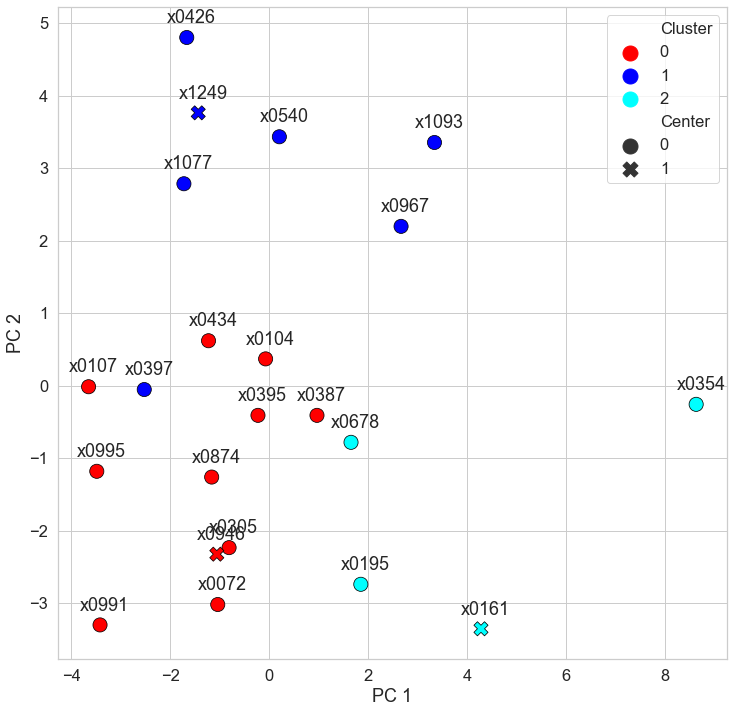

In [30]:
pal = dict([(str(x),y) for x,y in zip(range(0,num_clusters),color_list)])
ax = sns.scatterplot(x="PC_1",y="PC_2",data=pca_df,s=200,hue="Cluster",palette=pal, style="Center", edgecolor='black')
ax.set(xlabel="PC 1",ylabel="PC 2")
for i,row in pca_df.iterrows():
    ax.text(row.PC_1-0.4,row.PC_2+0.2,row.structure)
plt.legend(markerscale=2.5)

### Plot the Chemical Strructures of the Ligands in Each Cluster

In [31]:
lig_buff = """Mpro-x0072	CS(=O)(=O)NCCC=1C=CC=CC1
Mpro-x0104	CC(=O)NCCC1=CNC=2C=CC(F)=CC12
Mpro-x0107	CC(=O)NC=1C=NC=CC1C
Mpro-x0161	COC(=O)C=1C=CC(=CC1)S(=O)(=O)N
Mpro-x0195	CN1CCCC=2C=CC(=CC12)S(=O)(=O)N
Mpro-x0305	CCNC=1C=CC(C#N)=CN1
Mpro-x0354	CN1CCN(CC1)C(=O)COC=2C=CC(C)=CC2
Mpro-x0387	OC1CCN(CC=2C=CSC2)CC1
Mpro-x0395	CC1=NN=C(CN2CCC=C(F)C2)S1
Mpro-x0397	CN(CC=1C=C(C)ON1)C(=O)NC2CC2
Mpro-x0426	FC=1C=CC=CC1C(=O)NCCC=2C=CN=CC2
Mpro-x0434	O=C(NC=1C=CC=CC1)NC=2C=CC=NC2
Mpro-x0540	O=C(NCCC=1C=CN=CC1)NC2CCCCC2
Mpro-x0678	O=C(CC1CCCCC1)NC=2C=CC=NC2
Mpro-x0874	O=C([C@@H]1[C@H](C2=CSC=C2)CCC1)N
Mpro-x0946	BrC1=CC=C(S(N)(=O)=O)C=C1
Mpro-x0967	CC(=O)NC(Cc1ccc(cc1)O)C(=O)NCC#CBr
Mpro-x0991	Cl.CCC(=N)N
Mpro-x0995	NC=1C=NC=NC1
Mpro-x1077	N#CC=1C=CC(=CN1)N2CCCOCC2
Mpro-x1093	CN1CCN(CC1)C(=O)CC1=CNC2=NC=CC=C12
Mpro-x1249	O=C(NCC=1C=CC(C#N)=CC1)N2CCOCC2"""

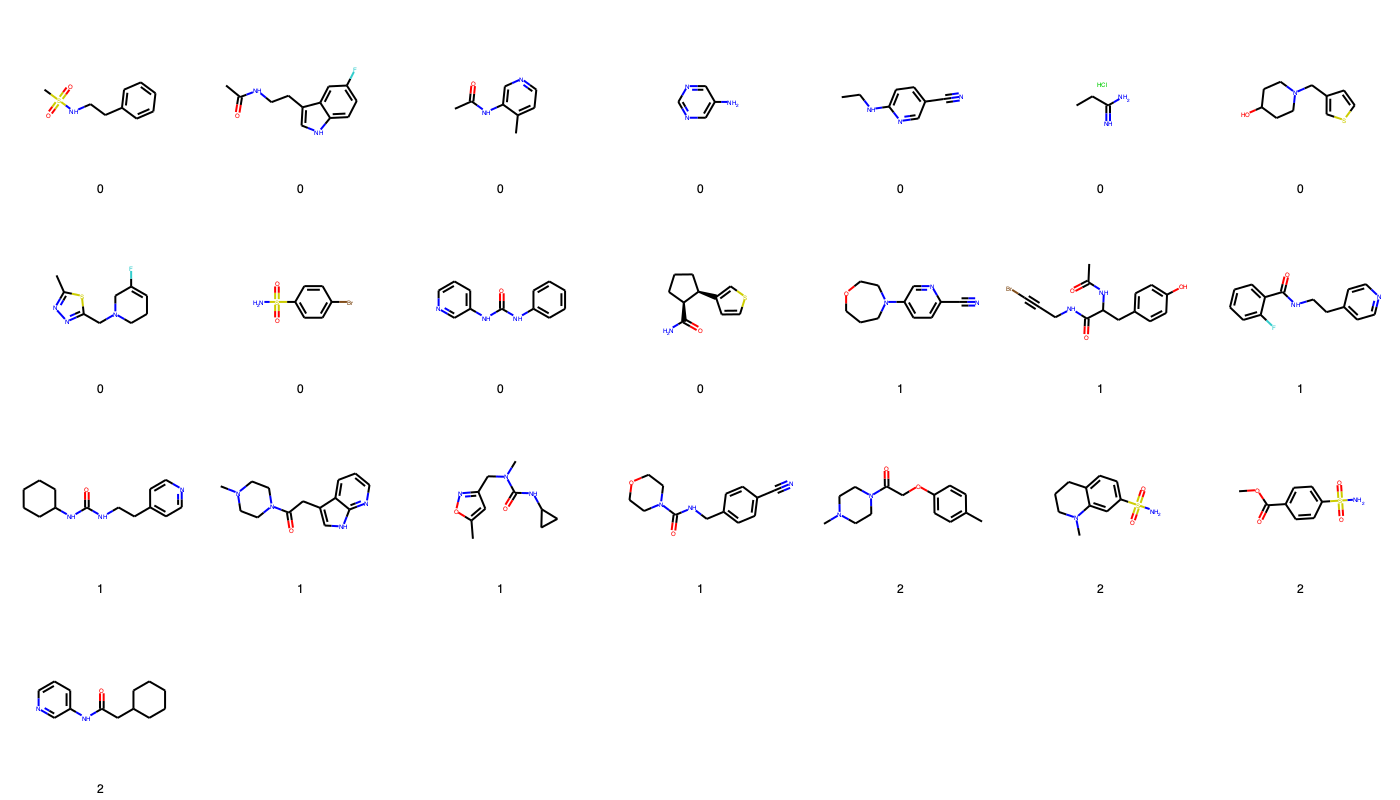

In [32]:
smiles_df = pd.DataFrame([x.split("\t") for x in lig_buff.split("\n")],columns=["Name","SMILES"])
smiles_df.Name = [x.split("-")[1] for x in smiles_df.Name]
combo_df = smiles_df.merge(pca_df,left_on="Name",right_on="structure")
combo_df.sort_values("Cluster",inplace=True)
combo_df['Mol'] = [Chem.MolFromSmiles(x) for x in combo_df.SMILES]
MolsToGridImage(combo_df.Mol,molsPerRow=7,legends=list(combo_df.Cluster))

### Are There Other Homologous Structures to Learn From?

In [33]:
# pull out the protein sequence for a blast search
ref = non_cov_prot_structs[0]
seq = ref['A'].getSequence()
seq

'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVT'

In [36]:
# use prody to blast search the PDB
blast_record = prody.blastPDB(seq, expect=10)
if blast_record:
    blast_df = pd.DataFrame(blast_record.getHits()).T
    homolog_df = blast_df[
        (blast_df['percent_identity'] > 80) & 
        (blast_df['percent_coverage'] > 80)
    ]
    homolog_df[['evalue','percent_identity','percent_coverage','pdb_id','chain_id','title']]
else:
    print("Could not reach the NCBI PDB database")

@> Blast searching NCBI PDB database for "SGFRK..."
@> WARNING Blast search time out.                    


Could not reach the NCBI PDB database


In [37]:
# The BLAST PDB database is out of date
# so do a manual search
with open('PDB_seq_search_results.txt') as f:
    pdb_ids = f.read().strip().split(',')

# one of these structures doesn't have a PDB file available
pdb_ids.remove('6Y7M')
    
print(' '.join(pdb_ids))
len(pdb_ids)

6LU7 6M2Q 6M2N 6W63 6Y84 6M03 5R7Z 5R8T 5RGP 5RGQ 5RGN 5RGO 5RGL 5RGM 5RGJ 5RGK 5RGR 5RGS 5R81 6Y2E 5R82 6Y2F 5R80 5R7Y 5R83 6Y2G 5R84 5RG0 5RFO 5RFP 5RG1 5RFM 5RFN 5RFK 5RFL 5RFI 5RFJ 5RFW 5RFX 5RFU 5RFV 5RFS 5RFT 5RG2 5RFQ 5RFR 5RG3 7BQY 5RFY 5RFZ 5RGH 5RGI 5RGG 6YB7 5REN 5REO 5RF0 5REL 5REM 5REJ 5REK 5REH 5REI 5REV 5RF7 5REW 5RF8 5RF5 5RET 5REU 5RF6 5RF3 5RER 5RF4 5RES 5RF1 5REP 5RF2 5REZ 5RF9 5REX 5REY 5RFG 5RFH 5RFE 5RFF 5RFC 5RFD 5RFA 5RFB 5RE6 5RE7 5RE4 5RE5 5RE8 5RE9 5REF 5REG 5RED 5REE 5REB 5REC 5REA 3VB6 3VB5 3VB4 3VB3 2GX4 3VB7 3IWM 3SZN 2Z94 2GTB 2Z9G 2Z9L 2Z9K 2Z9J 3TIU 3TIT 2GT7 2GT8 2A5I 2A5K 2BX3 2BX4 2A5A 5N5O 2H2Z 2ZU4 2ZU5 2Z3E 2Z3D 2Z3C 2HOB 5N19 1Q2W 1UK2 1UK3 1UK4 1WOF 2C3S 1UJ1 2DUC 1Z1I 2D2D 3SN8 2AMD 3SNE 3SND 3SNC 3SNB 2GZ7 3V3M 2GZ8 2AMQ 2V6N 2GZ9 3TNT 3TNS 3E91 3F9E 2VJ1 3M3V 3EA8 3EA7 2PWX 2QCY 4HI3 3M3T 2ALV 5C5N 5C5O 3AW0 3AW1 3AVZ 4TWY 4TWW 3ATW 3F9H 2QC2 3F9F 4MDS 4WY3 3M3S 5B6O 1Z1J 2Q6G 3EA9 3EAJ 2OP9 3SNA 2QIQ 3F9G 3FZD 3D62 5WKM 5WKK 5WKL 5WKJ 5C3N 

236

In [38]:
# create local directory for new structures
struct_dir = './PDB_Mpro_structures'
if not os.path.exists(struct_dir): os.mkdir(struct_dir)
prody.pathPDBFolder(folder=struct_dir)

# download structures into our directory
PDB_Mpro_structs = prody.parsePDB(pdb_ids)

@> Local PDB folder is set: '/Users/pwalters/software/mpro_analysis/PDB_Mpro_structures'
@> A plain folder structure will be assumed.
@> 236 PDBs were parsed in 272.65s.


### Let's align all these structures

In [39]:
# create local directory for aligned structures
struct_dir = './PDB_Mpro_structures_aligned'
if not os.path.exists(struct_dir): os.mkdir(struct_dir)

# perform alignment and generate new files
ref = non_cov_prot_structs[0]
for struct in PDB_Mpro_structs:
    alignment = prody.matchAlign(struct, ref)
    if alignment:
        aligned_struct = alignment[0]
        outfile = f'{struct_dir}/{struct.getTitle()}_aligned.pdb'
        prody.writePDB(outfile, aligned_struct)

@> Checking AtomGroup 6LU7: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 6LU7 (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 99% overlap.
@>   Comparing Chain C from 6LU7 (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 74.94
@> After alignment  RMSD: 1.54
@> Checking AtomGroup 6M2Q: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 6M2Q (len=305) and Chain A from Mpro-x0995_1 Selection 'heavy' 

@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RGJ (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.16
@> After alignment  RMSD: 0.15
@> Checking AtomGroup 5RGK: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RGK (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.18
@> After alignment  RMSD: 0.16
@> Checking AtomGroup 5RGR: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection '

@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.91
@> After alignment  RMSD: 0.29
@> Checking AtomGroup 5RG1: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RG1 (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.21
@> After alignment  RMSD: 0.20
@> Checking AtomGroup 5RFM: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RFM (len=304) and Chain A from Mpro-x0995

@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RFR (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.23
@> After alignment  RMSD: 0.22
@> Checking AtomGroup 5RG3: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RG3 (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.16
@> After alignment  RMSD: 0.15
@> Checking AtomGroup 7BQY: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection '

@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.18
@> After alignment  RMSD: 0.17
@> Checking AtomGroup 5REH: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5REH (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.44
@> After alignment  RMSD: 0.33
@> Checking AtomGroup 5REI: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5REI (len=304) and Chain A from Mpro-x0995

@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5REP (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.20
@> After alignment  RMSD: 0.19
@> Checking AtomGroup 5RF2: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RF2 (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.18
@> After alignment  RMSD: 0.16
@> Checking AtomGroup 5REZ: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection '

@> Before alignment RMSD: 0.20
@> After alignment  RMSD: 0.18
@> Checking AtomGroup 5RE4: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RE4 (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 0.25
@> After alignment  RMSD: 0.21
@> Checking AtomGroup 5RE5: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5RE5 (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 100% sequence identity and 100% overlap.
@>

@> 	Match: 301 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain B from 3VB4 (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain E from 3VB4 (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@>   Comparing Chain F from 3VB4 (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 42.22
@> After alignment  RMSD: 0.93
@> Checking AtomGroup 3VB3: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 3VB3 (len=301) and Chain A from

@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 62.59
@> After alignment  RMSD: 1.00
@> Checking AtomGroup 2Z9J: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2Z9J (len=302) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 302 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain B from 2Z9J (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 66.91
@> After alignment  RMSD: 1.02
@> Checking AtomGroup 3TIU: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying t

@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2Z3E (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain I from 2Z3E (len=2) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 34.73
@> After alignment  RMSD: 1.68
@> Checking AtomGroup 2Z3D: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2Z3D (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain I from 2Z3D (len=3) and C

@>   Comparing Chain B from 1UJ1 (len=302) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 302 residues match with 96% sequence identity and 99% overlap.
@> Alignment is based on 302 atoms matching 'calpha'.
@> Before alignment RMSD: 55.49
@> After alignment  RMSD: 0.89
@> Checking AtomGroup 2DUC: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2DUC (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain B from 2DUC (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 99% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 55.

@> After alignment  RMSD: 1.67
@> Checking AtomGroup 2AMQ: 4 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2AMQ (len=303) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 302 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain B from 2AMQ (len=302) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 302 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain C from 2AMQ (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@>   Comparing Chain D from 2AMQ (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@> Alignment is based o

@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 4HI3 (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 300 residues match with 96% sequence identity and 99% overlap.
@>   Comparing Chain B from 4HI3 (len=301) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 301 residues match with 96% sequence identity and 99% overlap.
@> Alignment is based on 301 atoms matching 'calpha'.
@> Before alignment RMSD: 36.99
@> After alignment  RMSD: 0.75
@> Checking AtomGroup 3M3T: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 3M3T (len=307) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304

@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2QC2 (len=305) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 100% overlap.
@>   Comparing Chain B from 2QC2 (len=305) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 304 residues match with 96% sequence identity and 100% overlap.
@> Alignment is based on 304 atoms matching 'calpha'.
@> Before alignment RMSD: 43.52
@> After alignment  RMSD: 1.22
@> Checking AtomGroup 3F9F: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 3F9F (len=299) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 299 residues match with 96% sequence identity and 98% overlap.
@>   Comparing Chai

@> Checking AtomGroup 2QIQ: 1 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2QIQ (len=301) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 301 residues match with 96% sequence identity and 99% overlap.
@> Alignment is based on 301 atoms matching 'calpha'.
@> Before alignment RMSD: 47.50
@> After alignment  RMSD: 0.86
@> Checking AtomGroup 3F9G: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 3F9G (len=297) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Match: 297 residues match with 96% sequence identity and 98% overlap.
@>   Comparing Chain B from 3F9G (len=295) and Chain A from Mpro-x0

@>  Comparing Chain D from 4YLU (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=52%, overlap=98%).
@> Checking AtomGroup 4WMF: 3 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 4WMF (len=304) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=24%, overlap=100%).
@>   Comparing Chain B from 4WMF (len=303) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=25%, overlap=100%).
@>   Comparing Chain C from 4WMF (len=289) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=24%, overlap=94%).
@> Trying to match chains based on global sequence alignment:
@>  Comparing Chain A fro

@>  Comparing Chain B from 4YOG (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=51%, overlap=98%).
@> Checking AtomGroup 2YNB: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2YNB (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=25%, overlap=99%).
@>   Comparing Chain B from 2YNB (len=302) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=25%, overlap=99%).
@> Trying to match chains based on global sequence alignment:
@>  Comparing Chain A from 2YNB (len=306) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=51%, overlap=98%).
@>  Comparing Chain B from 2

@> 	Failed to match chains (seqid=46%, overlap=99%).
@>  Comparing Chain B from 5HYO (len=301) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=46%, overlap=99%).
@> Checking AtomGroup 5GWZ: 4 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain B from 5GWZ (len=299) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=13%, overlap=98%).
@>   Comparing Chain A from 5GWZ (len=299) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=13%, overlap=98%).
@>   Comparing Chain D from 5GWZ (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@>   Comparing Chain E from 5GWZ (len=3)

@> 	Failed to match chains (seqid=100%, overlap=1%).
@>  Comparing Chain H from 4ZRO (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=100%, overlap=1%).
@> Checking AtomGroup 5EU8: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5EU8 (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=98%).
@>   Comparing Chain B from 5EU8 (len=3) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=1%).
@> Trying to match chains based on global sequence alignment:
@>  Comparing Chain A from 5EU8 (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=

@> 	Failed to match chains (seqid=14%, overlap=99%).
@>   Comparing Chain C from 1P9U (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=99%).
@>   Comparing Chain D from 1P9U (len=301) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=99%).
@>   Comparing Chain E from 1P9U (len=299) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=98%).
@>   Comparing Chain F from 1P9U (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=99%).
@>   Comparing Chain G from 1P9U (len=6) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=0%, overlap=0%).
@>   Comparing Chain H from 1P9U (len=6) and Chain A from Mpro-x0995_1 Selec

@> 	Failed to match chains (seqid=43%, overlap=97%).
@>  Comparing Chain B from 1P9S (len=299) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=43%, overlap=97%).
@> Checking AtomGroup 2ZU2: 2 chains are identified
@> Checking AtomGroup Mpro-x0995_1 Selection 'heavy' Selection 'protein': 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 2ZU2 (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=99%).
@>   Comparing Chain B from 2ZU2 (len=301) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (seqid=14%, overlap=99%).
@> Trying to match chains based on global sequence alignment:
@>  Comparing Chain A from 2ZU2 (len=300) and Chain A from Mpro-x0995_1 Selection 'heavy' Selection 'protein' (len=304):
@> 	Failed to match chains (

In [40]:
file_list = glob.glob("./PDB_Mpro_structures_aligned/*.pdb")

In [41]:
@interact(pdb_file = file_list)
def show_pdb(pdb_file):
    p = py3Dmol.view(500, 500)
    buff = open(pdb_file).read()
    p.addModel(buff, 'pdb')
    p.setStyle({'cartoon': {'color':'spectrum'}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p

interactive(children=(Dropdown(description='pdb_file', options=('./PDB_Mpro_structures_aligned/5RFY_aligned.pd…